In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import where as IF
import scipy.stats as stats

In [2]:
#1)Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [4]:
claims = pd.read_csv("claims.csv")
demo = pd.read_csv("cust_demographics.csv")

In [5]:
claims

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1.0,No
...,...,...,...,...,...,...,...,...,...,...
1095,97727122,35951012,Other driver error,06/11/2017,Auto,No,Material only,$3059,4.0,Yes
1096,10247193,14818669,Natural causes,03/14/2018,Auto,No,Material only,$1520,2.0,No
1097,79807493,85322831,Other driver error,02/09/2018,Auto,No,Material and injury,$23575,2.0,Yes
1098,69299345,73449366,Other causes,03/21/2018,Auto,Unknown,Material and injury,$25120,1.0,No


In [6]:
demo

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold
...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver


In [7]:
comb_df = pd.merge(right = claims,
                   left = demo, 
                   right_on = "customer_id", 
                   left_on = "CUST_ID",
                   how = "outer"
                  )
comb_df.drop(columns = ["customer_id"], inplace = True)
comb_df.head(2)

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,21868593.0,Female,12-Jan-79,VT,789-916-8172,Platinum,54004764.0,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,75740424.0,Female,13-Jan-70,ME,265-543-1264,Silver,33985796.0,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No


In [8]:
#2. Perform a data audit for the datatypes and find out if there are any
#mismatch within the current datatypes of the columns and their business significance.

In [9]:
comb_df["DateOfBirth"] = pd.to_datetime(comb_df.DateOfBirth, format = "%d-%b-%y")
comb_df.loc[(comb_df.DateOfBirth.dt.year > 2020),"DateOfBirth"]=comb_df[comb_df.DateOfBirth.dt.year > 2020]["DateOfBirth"].apply(lambda x: x - pd.DateOffset(years=100))
comb_df["claim_date"] = pd.to_datetime(comb_df.claim_date, format = "%m/%d/%Y")
comb_df["Contact"] = pd.to_numeric(comb_df.Contact.str.replace("-",""),downcast='float')

In [10]:
#3Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign.

In [11]:
comb_df["claim_amount"] = pd.to_numeric(comb_df.claim_amount.str.replace("$",""),downcast='float')
comb_df.head(2)

C:\Users\Deekshitha Raji\AppData\Local\Temp\ipykernel_11056\2503011791.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comb_df["claim_amount"] = pd.to_numeric(comb_df.claim_amount.str.replace("$",""),downcast='float')


,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,21868593.0,Female,1979-01-12,VT,7.899168e+09,Platinum,54004764.0,Driver error,2017-11-27,Auto,No,Material only,2980.0,1.0,No
1,75740424.0,Female,1970-01-13,ME,2.655431e+09,Silver,33985796.0,Crime,2018-10-03,Home,Unknown,Material only,2980.0,3.0,No


In [12]:
#4)Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.

In [13]:
comb_df["flag"] = IF(comb_df.police_report == "No", 0 ,
                    IF(comb_df.police_report == "Yes", 1, np.nan))
comb_df.drop(columns = ["police_report"], inplace = True)

In [14]:
#5)One customer can claim for insurance more than once and in each claim, multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [22]:
comb_df = comb_df.groupby('CUST_ID').first().reset_index(drop = True)

KeyError: 'CUST_ID'

In [19]:
#6)Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [20]:
comb_df["incident_cause"].isna().sum()

7

In [21]:
cat_col = ["gender","State","Segment","incident_cause","claim_area","claim_type","fraudulent","flag"]
con_col = ["claim_amount"]

In [23]:
for col in cat_col:
    comb_df[col] = comb_df[col].fillna(comb_df[col].mode()[0])
comb_df[con_col] = comb_df[con_col].fillna(comb_df[con_col].mean())
comb_df.head()

,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,flag
0,Female,1978-05-23,DE,9.628791e+09,Platinum,69348631.0,Driver error,2018-04-10,Auto,Injury only,12470.501953,1.0,Yes,0.0
1,Male,1972-12-20,TX,1.738926e+09,Silver,40953049.0,Other causes,2018-04-04,Auto,Material and injury,39192.000000,1.0,Yes,0.0
2,Male,1988-07-28,FL,3.645981e+09,Silver,45780237.0,Natural causes,2017-10-17,Auto,Material only,1621.500000,2.0,Yes,0.0
3,Male,1971-08-19,CA,1.873488e+09,Gold,89833962.0,Other causes,2018-03-21,Auto,Material and injury,37040.000000,1.0,No,1.0
4,Female,1980-08-10,NC,7.988625e+09,Gold,35782742.0,Other driver error,2018-07-27,Auto,Injury only,35250.000000,3.0,No,0.0


In [24]:
# comb_df["incident_cause"].fillna(0, inplace =True)
comb_df["State"].isna().sum()

0

In [25]:
#7Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria

In [26]:
comb_df["Age"] = round((comb_df.claim_date - comb_df.DateOfBirth).apply(lambda x: x.days)/365.25, 2)

In [27]:
comb_df["Age_grp"] = IF(comb_df.Age < 18, "Children",
                        IF(comb_df.Age < 30, "Youth",
                         IF(comb_df.Age < 60, "Adult",
                          IF(comb_df.Age < 100, "Senior", "NaN"
                           
                          )
                         )
                        )
                       )
comb_df["Age_grp"] = comb_df["Age_grp"].fillna(comb_df["Age_grp"].mode())
comb_df.groupby(by = "Age_grp").count()
# comb_df.head()

,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,flag,Age
Age_grp,,,,,,,,,,,,,,,
Adult,744,744,744,744,744,744,744,744,744,744,744,736,744,744,744
Children,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
NaN,7,7,7,7,7,0,7,0,7,7,7,0,7,7,0
Youth,326,326,326,326,326,326,326,326,326,326,326,324,326,326,326


In [28]:
#8What is the average amount claimed by the customers from various segments?

In [29]:
comb_df.groupby(by = "Segment")[["claim_amount"]].mean()

,claim_amount
Segment,
Gold,12755.710938
Platinum,12370.138672
Silver,12271.163086


In [30]:
#9What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [31]:
comb_df.loc[comb_df.claim_date < "2018-09-10",:].groupby("incident_cause")["claim_amount"].sum().add_prefix("total_")

incident_cause
total_Crime                  724462.5
total_Driver error          3264286.0
total_Natural causes        1312706.0
total_Other causes          3725038.5
total_Other driver error    3318806.5
Name: claim_amount, dtype: float32

In [32]:
#10)How many adults from TX, DE and AK claimed insurance for driver related issues and causes?

In [33]:
comb_df.loc[(comb_df.incident_cause.str.lower().str.contains("driver") 
             & ((comb_df.State == "TX") | (comb_df.State == "DE") | (comb_df.State == "AK"))),:].groupby(by = "State")["State"].count()

State
AK    10
DE    15
TX    10
Name: State, dtype: int64

In [34]:
#11)Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage onthe pie chart.

In [35]:
f1 = comb_df.groupby(by = ["gender","Segment"])["claim_amount"].sum().reset_index()
f1.head()

,gender,Segment,claim_amount
0,Female,Gold,2122234.0
1,Female,Platinum,2381974.0
2,Female,Silver,1935970.0
3,Male,Gold,2622890.5
4,Male,Platinum,2120756.5


In [36]:
res = f1.pivot(index = "Segment", columns = "gender", values = "claim_amount")
res

gender,Female,Male
Segment,,
Gold,2122234.0,2622890.5
Platinum,2381974.0,2120756.5
Silver,1935970.0,2346666.0


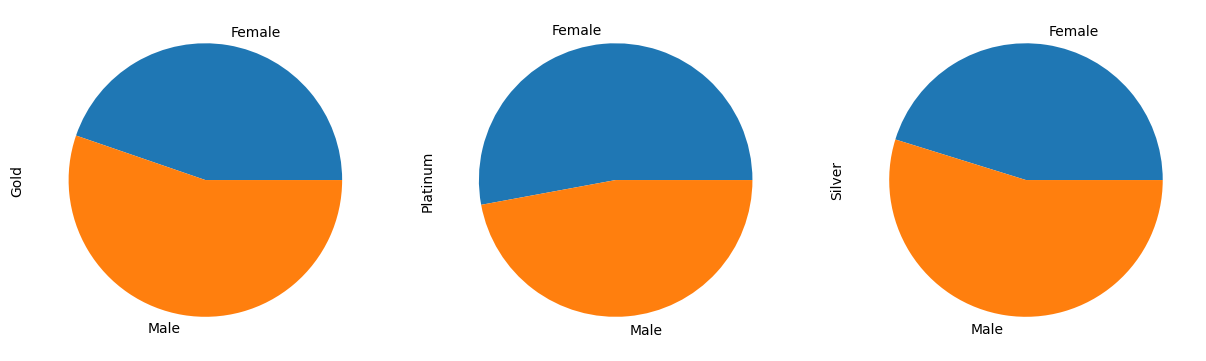

In [37]:
res.T.plot(kind = "pie", subplots = True, legend = False, figsize = (15,8))
plt.show()

In [38]:
#12 Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

In [39]:
f2 = comb_df.loc[(comb_df.incident_cause.str.lower().str.contains("driver"))].groupby(by = "gender")[["gender"]].count().add_prefix("CountOf_").reset_index()
f2

,gender,CountOf_gender
0,Female,221
1,Male,280


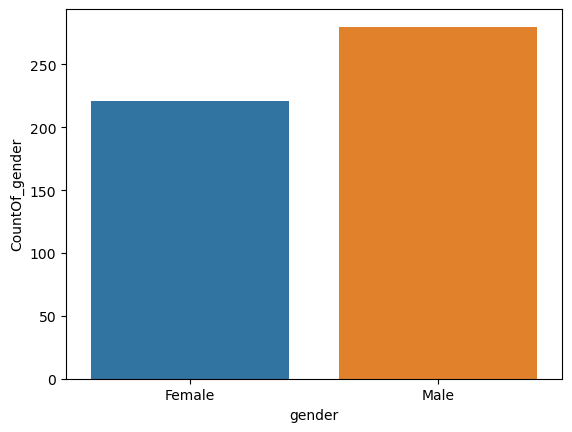

In [40]:
sns.barplot(x = "gender", y = "CountOf_gender", data = f2 )
plt.show()

In [41]:
#13) Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.

In [42]:
comb_df.groupby(by = "Age_grp")[["fraudulent"]].count()

,fraudulent
Age_grp,
Adult,744
Children,8
NaN,7
Youth,326


In [43]:
comb_df[(comb_df.Age_grp == np.nan)]

,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,flag,Age,Age_grp


In [44]:
val = comb_df['Age_grp'].mode()[0]
print(val)
comb_df.loc[:,"Age_grp"] = comb_df.loc[:,'Age_grp'].fillna(value = val)

Adult


In [45]:
comb_df[(comb_df.Age_grp == "nan")]

,gender,DateOfBirth,State,Contact,Segment,claim_id,incident_cause,claim_date,claim_area,claim_type,claim_amount,total_policy_claims,fraudulent,flag,Age,Age_grp


In [46]:
comb_df['Age_grp'].mode()[0]

'Adult'

In [47]:
#14 Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

In [48]:
monthly_trend = comb_df.groupby(["claim_date"])[["claim_amount"]].sum().reset_index()

In [49]:
monthly_trend['Monthly'] = monthly_trend['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%B"))
monthly_trend['Yearly'] = monthly_trend['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%Y"))

In [50]:
monthly_trend_data = monthly_trend.groupby(["Monthly"])[["claim_amount"]].sum().reset_index()

In [51]:
monthly_trend_data

,Monthly,claim_amount
0,April,1276071.5
1,August,911203.5
2,December,696701.5
3,February,1133107.0
4,January,1332012.0
5,July,1379035.0
6,June,1276333.0
7,March,1320094.0
8,May,1114211.5
9,November,601125.0


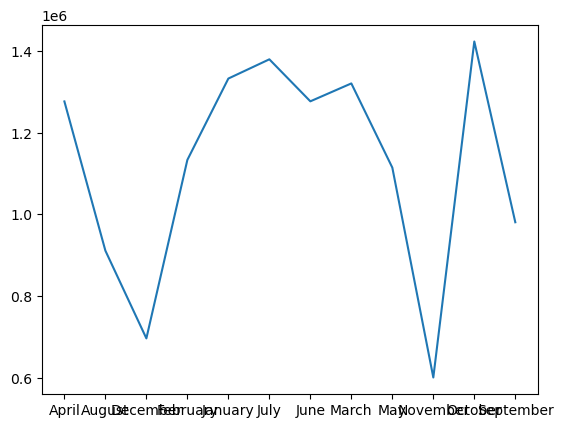

In [52]:
plt.plot(monthly_trend_data['Monthly'], monthly_trend_data['claim_amount'], label = 'Trend Line')

In [53]:
#15) 

In [54]:
Avg_Claim_Amt = comb_df.groupby(["gender","Age_grp","fraudulent"])[["claim_amount"]].mean().reset_index()

In [55]:
Avg_Claim_Amt_Male = Avg_Claim_Amt.loc[ Avg_Claim_Amt.gender == 'Male', ['claim_amount','Age_grp','fraudulent'] ]
Avg_Claim_Amt_Female = Avg_Claim_Amt.loc[ Avg_Claim_Amt.gender == 'Female', ['claim_amount','Age_grp','fraudulent'] ]

In [56]:
Avg_Claim_Amt_Male_fraudulent = Avg_Claim_Amt_Male.loc[ Avg_Claim_Amt.fraudulent == 'Yes', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Male_nonfraudulent = Avg_Claim_Amt_Male.loc[ Avg_Claim_Amt.fraudulent == 'No', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Female_fraudulent = Avg_Claim_Amt_Female.loc[ Avg_Claim_Amt.fraudulent == 'Yes', ['claim_amount','Age_grp'] ]
Avg_Claim_Amt_Female_nonfraudulent = Avg_Claim_Amt_Female.loc[ Avg_Claim_Amt.fraudulent == 'No', ['claim_amount','Age_grp'] ]

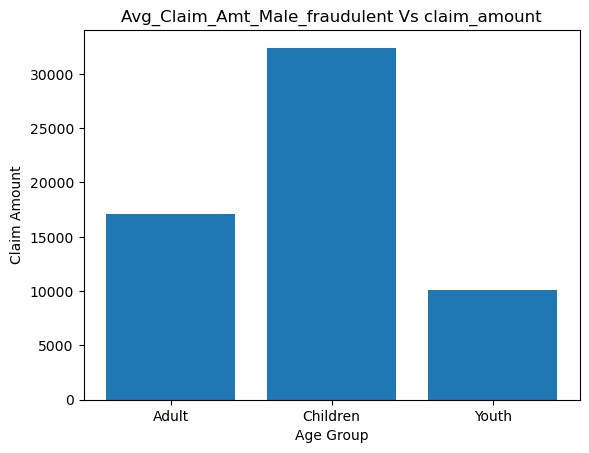

In [57]:
plt.bar(Avg_Claim_Amt_Male_fraudulent.Age_grp , Avg_Claim_Amt_Male_fraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Male_fraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

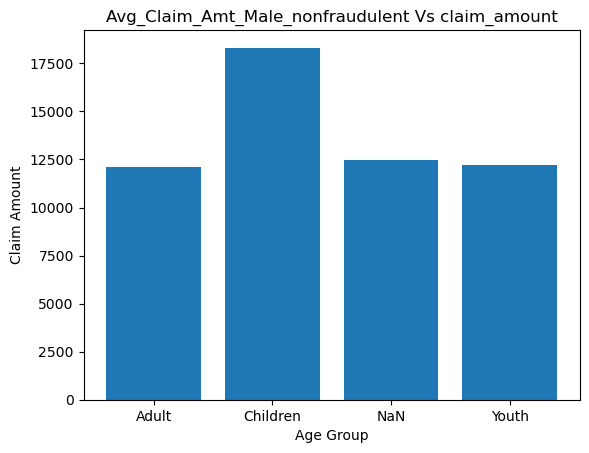

In [58]:
plt.bar(Avg_Claim_Amt_Male_nonfraudulent.Age_grp , Avg_Claim_Amt_Male_nonfraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Male_nonfraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

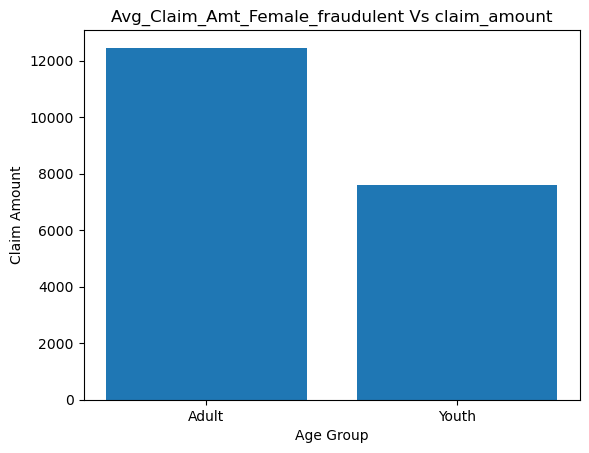

In [59]:
plt.bar(Avg_Claim_Amt_Female_fraudulent.Age_grp , Avg_Claim_Amt_Female_fraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Female_fraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

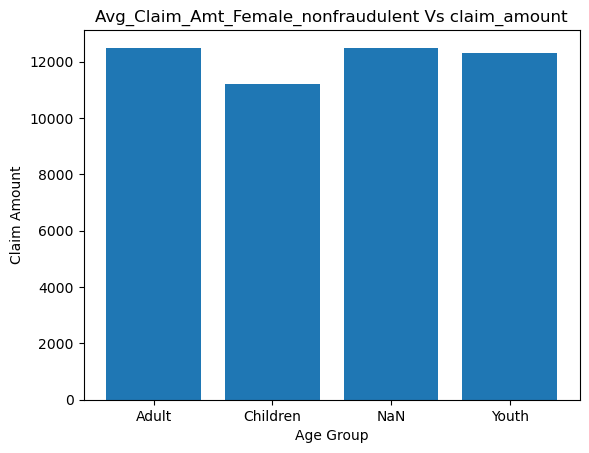

In [60]:
plt.bar(Avg_Claim_Amt_Female_nonfraudulent.Age_grp , Avg_Claim_Amt_Female_nonfraudulent.claim_amount)
plt.title('Avg_Claim_Amt_Female_nonfraudulent Vs claim_amount')
plt.xlabel('Age Group')
plt.ylabel('Claim Amount')
plt.show()

In [61]:
#16 Is there any similarity in the amount claimed by males and females?

In [62]:
#1. H0 - No relationship Ha - There is a relationship for the amount claimed by males and females CI - 95% p - 0.05 2. Analysis plan formulation Significance level : We will test our hypothesis at 5% significance level

In [63]:
comb_df.gender.value_counts()

Male      553
Female    532
Name: gender, dtype: int64

In [64]:
comb_df.columns

Index(['gender', 'DateOfBirth', 'State', 'Contact', 'Segment', 'claim_id',
       'incident_cause', 'claim_date', 'claim_area', 'claim_type',
       'claim_amount', 'total_policy_claims', 'fraudulent', 'flag', 'Age',
       'Age_grp'],
      dtype='object')

In [65]:
comb_df_Gender =  comb_df.groupby(["gender", "claim_date"])[["claim_amount"]].sum().reset_index()

In [66]:
#creating new columns which show "Month" and "Year"
comb_df_Gender['Monthly'] = comb_df_Gender['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%B"))
comb_df_Gender['Yearly'] = comb_df_Gender['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%Y"))

In [67]:
comb_df_Gender.head()

,gender,claim_date,claim_amount,Monthly,Yearly
0,Female,2017-01-01,119620.000000,January,2017
1,Female,2017-01-07,4576.500000,January,2017
2,Female,2017-01-14,85203.000000,January,2017
3,Female,2017-01-21,23379.501953,January,2017
4,Female,2017-01-27,6507.500000,January,2017


In [68]:
Claim_amt = 'claim_amount'

male_spend = comb_df_Gender.loc[ comb_df_Gender.gender == "Male", Claim_amt ]
female_spend = comb_df_Gender.loc[ comb_df_Gender.gender == "Female", Claim_amt ]

print( 'mean of male spend: ', male_spend.mean(), '| mean of female spend: ', female_spend.mean() )

mean of male spend:  71367.390625 | mean of female spend:  63778.25390625


In [ ]:
#H0 - u1 = u2 Ha - u1 <> u2 CI - 95% p - 0.05

In [71]:
stats.ttest_ind( male_spend, female_spend )

Ttest_indResult(statistic=1.3269766864615602, pvalue=0.18605237044651896)

In [72]:
stats.f_oneway( male_spend, female_spend )

F_onewayResult(statistic=1.760868249357575, pvalue=0.186052230728328)

In [73]:
print (" Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship for the amount claimed by males and females" )

 Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship for the amount claimed by males and females


In [74]:
#17 Is there any relationship between age category and segment?

In [75]:
#H0 - No relationship Ha - There is a relationship among the variables- relationship between age category and segment CI - 95% p - 0.05

In [76]:
obs_freq = pd.crosstab( comb_df.Segment, comb_df.Age_grp )

In [77]:
obs_freq

Age_grp,Adult,Children,NaN,Youth
Segment,,,,
Gold,262,4,1,105
Platinum,241,4,3,116
Silver,241,0,3,105


In [78]:
stats.chi2_contingency( obs_freq )

(6.349304779939778,
 0.3852189604208803,
 6,
 array([[255.08571429,   2.74285714,   2.4       , 111.77142857],
        [249.6       ,   2.68387097,   2.3483871 , 109.36774194],
        [239.31428571,   2.57327189,   2.2516129 , 104.86082949]]))

In [79]:
print (" Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship between age category and segment" )

 Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no relationship between age category and segment


In [80]:
#18 The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

In [81]:
comb_df_new =  comb_df.groupby(["claim_date"])[["claim_amount"]].sum().reset_index()

In [82]:
#creating new columns which show "Month" and "Year"
comb_df_new['Monthly'] = comb_df_new['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%B"))
comb_df_new['Yearly'] = comb_df_new['claim_date'].apply(lambda x:pd.Timestamp.strftime(x,format="%Y"))

In [83]:
comb_df_new

,claim_date,claim_amount,Monthly,Yearly
0,2017-01-01,203227.0,January,2017
1,2017-01-07,137763.5,January,2017
2,2017-01-14,138807.5,January,2017
3,2017-01-21,72576.5,January,2017
4,2017-01-27,57928.0,January,2017
...,...,...,...,...
95,2018-10-03,162797.5,October,2018
96,2018-10-09,225007.5,October,2018
97,2018-10-16,119829.0,October,2018
98,2018-10-23,147084.0,October,2018


In [84]:
comb_df_new_2017 = comb_df_new.loc[ comb_df_new.Yearly == '2017', 'claim_amount' ].mean()
print( comb_df_new_2017 )

133465.859375


In [85]:
comb_df_new_2018 = comb_df_new.loc[ comb_df_new.Yearly == '2018', 'claim_amount' ]

H0 - u <= 10000 Ha - u > 10000

CI - 95% p - 0.05

In [87]:
stats.ttest_1samp( comb_df_new_2018, 100000 )

Ttest_1sampResult(statistic=4.62313211888085, pvalue=3.310964302614461e-05)

Output: We reject the H0 Business Conclusion: Spend on the Insurance Claims has increased from last year spend of $100,000

In [88]:
#19 Is there any difference between age groups and insurance claims?

In [89]:
comb_df.Age_grp.nunique()

4

In [90]:
comb_df.Age_grp.value_counts()

Adult       744
Youth       326
Children      8
NaN           7
Name: Age_grp, dtype: int64

In [91]:
comb_df.columns

Index(['gender', 'DateOfBirth', 'State', 'Contact', 'Segment', 'claim_id',
       'incident_cause', 'claim_date', 'claim_area', 'claim_type',
       'claim_amount', 'total_policy_claims', 'fraudulent', 'flag', 'Age',
       'Age_grp'],
      dtype='object')

In [92]:
Claims = 'claim_amount'

In [93]:
# data processing for the test
s1 = comb_df.loc[ comb_df.Age_grp == 'Adult', Claims ]
s2 = comb_df.loc[ comb_df.Age_grp == 'Youth', Claims ]
s3 = comb_df.loc[ comb_df.Age_grp == 'NaN', Claims ]
s4 = comb_df.loc[ comb_df.Age_grp == 'Children', Claims ]

print( 'Count s1:', s1.mean(), '| Count s2:', s2.mean(), '| Count s3:', s3.mean(), 
       '| Count s3:', s4.mean() )

Count s1: 12837.2490234375 | Count s2: 11490.4404296875 | Count s3: 12470.5009765625 | Count s3: 18300.875


H0 - means are from same population (difference between age groups and insurance claims) Ha - means are from different population CI - 95% p - 0.05

In [94]:
stats.f_oneway( s1, s2, s3, s4 )

F_onewayResult(statistic=1.2877623271900271, pvalue=0.27719067054639274)

In [95]:
print (" Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no difference between age groups and insurance claims" )

 Business conclusion: Pvalue is > 0.05. Hence we accept Null Hypothesis H0 and There is no difference between age groups and insurance claims


In [96]:
#20 Is there any relationship between total number of policy claims and the claimed amount?

In [97]:
comb_df.total_policy_claims.value_counts()

1.0    781
2.0    104
3.0     86
4.0     58
5.0     27
6.0      9
7.0      2
8.0      1
Name: total_policy_claims, dtype: int64

In [98]:
comb_df.columns

Index(['gender', 'DateOfBirth', 'State', 'Contact', 'Segment', 'claim_id',
       'incident_cause', 'claim_date', 'claim_area', 'claim_type',
       'claim_amount', 'total_policy_claims', 'fraudulent', 'flag', 'Age',
       'Age_grp'],
      dtype='object')

In [99]:
usage = 'claim_amount'

In [100]:
# data processing for the test
s1 = comb_df.loc[ comb_df.total_policy_claims == 1.0, usage ]
s2 = comb_df.loc[ comb_df.total_policy_claims == 2.0, usage ]
s3 = comb_df.loc[ comb_df.total_policy_claims == 3.0, usage ]
s4 = comb_df.loc[ comb_df.total_policy_claims == 4.0, usage ]
s5 = comb_df.loc[ comb_df.total_policy_claims == 5.0, usage ]
s6 = comb_df.loc[ comb_df.total_policy_claims == 6.0, usage ]
s7 = comb_df.loc[ comb_df.total_policy_claims == 7.0, usage ]
s8 = comb_df.loc[ comb_df.total_policy_claims == 8.0, usage ]

print( 'mean s1:', s1.mean(), '| mean s2:', s2.mean(), '| mean s3:', s3.mean(),'mean s4:', s4.mean(), 
       '| mean s5:', s5.mean(), '| mean s6:', s6.mean(),'|mean s7:', s7.mean(), '| mean s8:', s2.mean(), '| mean s8:', s3.mean() )

mean s1: 12403.6552734375 | mean s2: 13876.4521484375 | mean s3: 12928.19140625 mean s4: 11049.724609375 | mean s5: 8530.462890625 | mean s6: 15657.8330078125 |mean s7: 23033.0 | mean s8: 13876.4521484375 | mean s8: 12928.19140625


H0 - means are from same population Ha - means are from different population CI - 95% p - 0.05

In [101]:
stats.f_oneway( s1, s2, s3, s4, s5, s6, s7, s8 )

F_onewayResult(statistic=0.9303871872119974, pvalue=0.4818261589585725)

Business conclusion: We accept the H0 There is Relationship between total number of policy claims and the claimed amount